# TODO:

Take all the changes in model.py and export to standalone functions for now.

Once that's ready, load the model from huggingface to see if it can handle this.

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import numpy as np
import torch
from torch.optim import AdamW
from visualization_utils import plot_sample, plot_prediction
from moondream_functions import detect, detect_grad
from dataset import load_object_detection_dataset
from moondream_cache import setup_caches
from rl_utils import calculate_reward
from moondream import MoondreamModel, MoondreamConfig
from safetensors.torch import load_file
from rl_utils import calculate_gpro_loss


BATCH_SIZE = 1
NUM_ROLLOUTS = 6
safetensors_path = "model.safetensors"
device = "mps"

torch.autograd.set_detect_anomaly(True)


/Users/noahkasmanoff/anaconda3/envs/torch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = MoondreamModel(config=MoondreamConfig)
state_dict = load_file(safetensors_path)
model.load_state_dict(state_dict)
model.to(device)

optimizer = AdamW(model.region.parameters(), lr=1e-4)

num_params = sum(p.numel() for p in model.region.parameters())
print(f"Number of parameters: {num_params:,}")

train_ds = load_object_detection_dataset("train")


Number of parameters: 60,317,312


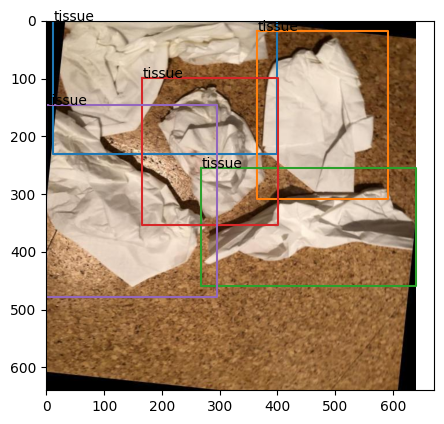

In [3]:


sample = train_ds[11]

plot_sample(sample)


# Data collection

In [4]:

def collect_experience(train_ds, model):
    experience = []
    for i in range(BATCH_SIZE):
        sample = train_ds[11]

        trajectory_detections = []

        for i in range(NUM_ROLLOUTS):
            detections = detect(model, sample[0], sample[1], None, temperature=1)
            trajectory_detections.append(detections)

        rewards = calculate_reward(trajectory_detections, sample)
        advantages = rewards - np.mean(rewards)

        advantages = advantages / np.std(advantages)

        advantages = torch.tensor(advantages, dtype=torch.float32).to(model.device)
        advantages = advantages.unsqueeze(1)

        group_experience = []
        for i, traj in enumerate(trajectory_detections):
            predictions = traj["objects"]
            advantage = advantages[i]
            logprobs = []
            for obj in predictions:
                x_logprob = obj["x_logprob"]
                y_logprob = obj["y_logprob"]
                w_logprob = obj["w_logprob"]
                h_logprob = obj["h_logprob"]
                logprobs.extend([x_logprob, y_logprob, w_logprob, h_logprob])

            # convert logits list to tensor
            logprobs = torch.tensor(logprobs, dtype=torch.float32).to(model.device)
            group_experience.append({"logprobs": logprobs, "advantage": advantage})
        experience.extend(group_experience)

    return experience, trajectory_detections

with torch.no_grad():
    experience, trajectory_detections = collect_experience(train_ds, model)


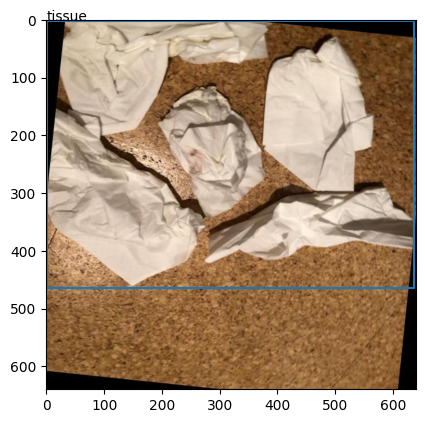

In [5]:
from visualization_utils import plot_sample, plot_prediction


plot_prediction(trajectory_detections[2], sample)

# Training Step

In [6]:


def train_step(experience, model, optimizer, train_ds):

    optimizer.zero_grad()
    total_loss = 0

    for i in range(BATCH_SIZE):
        sample = train_ds[11]

        new_predictions = detect_grad(model, sample[0], sample[1], None, temperature=0)
        new_logprobs = torch.stack(new_predictions["out_logprobs"]).reshape(
            -1, len(new_predictions["out_logprobs"])
        )

        old_logprobs_stack = []  # the prior log probs for the same corresponding sample
        advantages_stack = []
        # truncate experience to only be for this sample
        trajectory_experience = experience[i * NUM_ROLLOUTS : (i + 1) * NUM_ROLLOUTS]

        attention_mask = torch.ones(
            len(trajectory_experience),
            new_logprobs.shape[-1],
            device=model.device,
        )

        for j in range(len(trajectory_experience)):

            # todo add padding and some kind of masking during gradient calculation
            group_experience_logprobs = trajectory_experience[j]["logprobs"]
            orig_len = len(group_experience_logprobs)
            # pad right with 0s to match new_logprobs.shape[-1]
            if orig_len < new_logprobs.shape[-1]:
                group_experience_logprobs = torch.cat(
                    [
                        group_experience_logprobs,
                        torch.zeros(
                            new_logprobs.shape[-1] - orig_len, device=model.device
                        ),
                    ]
                )
                # set attention mask to 0 for the padded tokens
                attention_mask[j, orig_len:] = 0
            elif orig_len > new_logprobs.shape[-1]:
                group_experience_logprobs = group_experience_logprobs[
                    : new_logprobs.shape[-1]
                ]  # truncate
            old_logprobs_stack.append(group_experience_logprobs)
            advantages_stack.append(trajectory_experience[j]["advantage"])

        advantages = torch.stack(advantages_stack)
        old_logprobs = torch.stack(old_logprobs_stack)

        gpro_loss = calculate_gpro_loss(
            new_logprobs, old_logprobs, advantages, attention_mask
        )
        total_loss += gpro_loss

    if BATCH_SIZE > 0:
        print("Loss: ", total_loss.item())
        final_loss = total_loss / BATCH_SIZE
        final_loss.backward()
        optimizer.step()

    return final_loss, new_predictions

In [7]:
loss, new_predictions = train_step(experience, model, optimizer, train_ds)

Loss:  0.2223154604434967


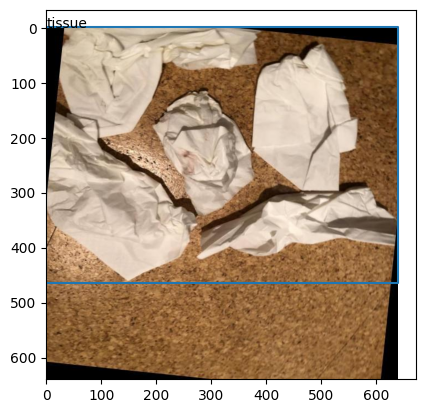

In [8]:
plot_prediction(new_predictions, sample)

In [9]:
loss, new_predictions = train_step(experience, model, optimizer, train_ds)

Loss:  -0.4075586497783661


In [10]:
loss, new_predictions = train_step(experience, model, optimizer, train_ds)

Loss:  -0.42354071140289307


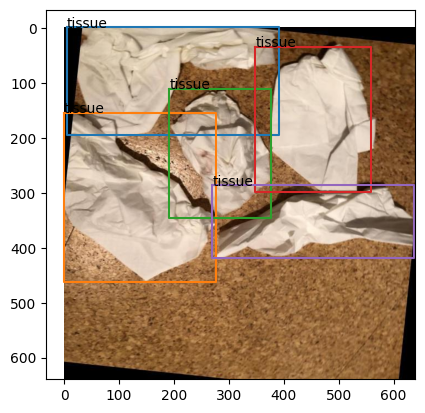

In [11]:
idx = 11
new_sample = train_ds[idx]
inference_predictions = detect(model, new_sample[0], new_sample[1], None, temperature=0)

plot_prediction(inference_predictions, new_sample)

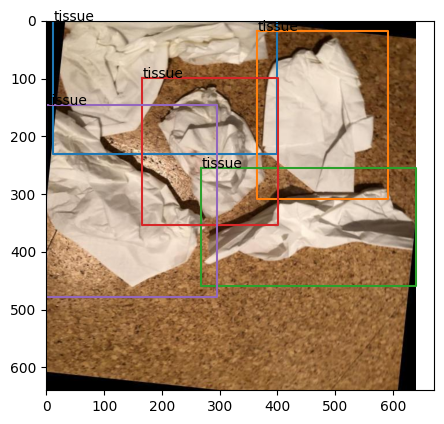

In [12]:
plot_sample(train_ds[11])

In [ ]:
# save model safetensors

from safetensors.torch import save_file

save_file(
    model.state_dict(),
    "moondream_finetune.safetensors",
)

In [14]:
# load model 
model = MoondreamModel(config=MoondreamConfig)
state_dict = load_file("moondream_finetune.safetensors")
model.load_state_dict(state_dict)
model.to("mps")






MoondreamModel(
  (vision): ModuleDict(
    (patch_emb): Linear(in_features=588, out_features=1152, bias=True)
    (blocks): ModuleList(
      (0-26): 27 x ModuleDict(
        (ln1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
        (attn): ModuleDict(
          (qkv): Linear(in_features=1152, out_features=3456, bias=True)
          (proj): Linear(in_features=1152, out_features=1152, bias=True)
        )
        (ln2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (fc1): Linear(in_features=1152, out_features=4304, bias=True)
          (fc2): Linear(in_features=4304, out_features=1152, bias=True)
        )
      )
    )
    (post_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (proj_mlp): ModuleDict(
      (fc1): Linear(in_features=2304, out_features=8192, bias=True)
      (fc2): Linear(in_features=8192, out_features=2048, bias=True)
    )
  )
  (text): ModuleDict(
    (blocks): ModuleList(
      (0-23): 24 x Mod

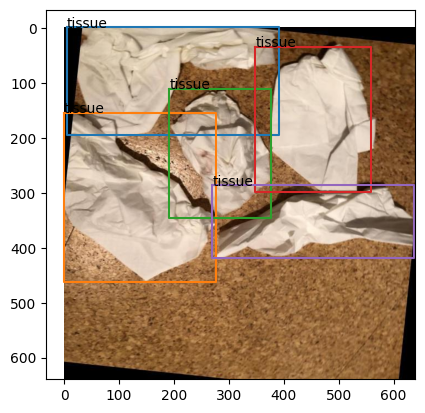

In [15]:
idx = 11
new_sample = train_ds[idx]
inference_predictions = detect(model, new_sample[0], new_sample[1], None, temperature=0)

plot_prediction(inference_predictions, new_sample)

Since the loss tensor is composed of both positive and negative values (coming from negative and positive advantages, respectively), the final gpro_loss (which is the mean) can be negative if the contributions from the positive-advantage actions are stronger than those from negative-advantage actions in a given batch.

Contributions from = higher 